<div style="background-color: #d40457; padding: 10px; border-radius: 8px;">
    <h1 style="color: #fff;">Importing Libraries</h1>
</div>

In [1]:
import os

import warnings

from IPython.display import HTML

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from nltk.corpus import stopwords
import re
from collections import Counter

from tqdm.auto import tqdm

In [2]:
color_list = ['#faa5c7', '#eb679c', '#cc3d76', '#b3245d', '#d40457', '#8f1042', '#6e042e']
color_palette = sns.color_palette(color_list)
sns.set_palette(color_palette)

# cmap = colors.ListedColormap(color_palette)
cmap = LinearSegmentedColormap.from_list('custom_palette', color_list, N=256)

warnings.filterwarnings("ignore")

<div style="background-color: #d40457; padding: 10px; border-radius: 8px;">
    <h1 style="color: #fff;">Device Configuration</h1>
</div>

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

<div style="background-color: #d40457; padding: 10px; border-radius: 8px;">
    <h1 style="color: #fff;">Importing Dataset</h1>
</div>

In [4]:
data = pd.read_csv('/kaggle/input/amazon-product-reviews/amazon.csv')
data.head()

,Text,label
0,This is the best apps acording to a bunch of ...,1
1,This is a pretty good version of the game for ...,1
2,this is a really . there are a bunch of levels...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


<div style="background-color: #d40457; padding: 10px; border-radius: 8px;">
    <h1 style="color: #fff;">Data Preprocessing</h1>
</div>

In [5]:
def preprocessString(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)
    return s

In [6]:
def getVocabulory(sentenceList):
    wordList = []

    stopWords = set(stopwords.words('english'))
    
    for sentence in sentenceList:
        for word in sentence.lower().split():
            processedWord = preprocessString(word)
            if processedWord not in stopWords and processedWord != '':
                wordList.append(processedWord)

    corpus = Counter(wordList)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    return onehot_dict

In [7]:
def preprocessData(data: pd.DataFrame):
    X, y = data.loc[:, 'Text'].values, data.loc[:, 'label'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y)
    print(f'X_train {X_train.shape} | X_test {X_test.shape} | y_train {y_train.shape} | y_test {y_test.shape}')
    
    vocab = getVocabulory(X_train)
    
    new_X_train, new_X_test = [], []
    
    for sentence in X_train:
        new_X_train.append([vocab[preprocessString(word)] for word in sentence.lower().split() if preprocessString(word) in vocab.keys()])
        
    for sentence in X_test:
        new_X_test.append([vocab[preprocessString(word)] for word in sentence.lower().split() if preprocessString(word) in vocab.keys()])
    
    return new_X_train, new_X_test, y_train, y_test, vocab

In [8]:
X_train, X_test, y_train, y_test, vocab = preprocessData(data)

X_train (15996,) | X_test (4000,) | y_train (15996,) | y_test (4000,)


<Axes: >

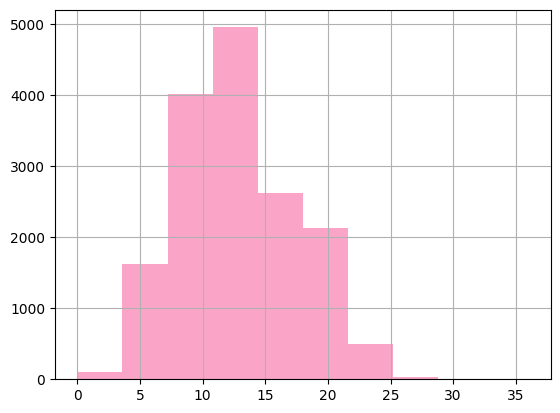

In [9]:
rev_len = [len(i) for i in X_train]
pd.Series(rev_len).hist()

In [10]:
def padding(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [11]:
X_train = padding(X_train, 30)
X_test = padding(X_test, 30)

In [12]:
X_train, y_train = torch.Tensor(X_train), torch.Tensor(y_train)
X_test, y_test = torch.Tensor(X_test), torch.Tensor(y_test)

In [13]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, drop_last = True)

<div style="background-color: #d40457; padding: 10px; border-radius: 8px;">
    <h1 style="color: #fff;">Creating the Network</h1>
</div>

In [14]:
def makeTheNet():
    class FakeNewsRNN(nn.Module):
        def __init__(self, no_layers, vocab_size, hidden_dim, embedding_dim, output_dim):
            super().__init__()

            self.no_layers = no_layers
            self.hidden_dim = hidden_dim
            self.output_dim = output_dim

            # Embedding Layer
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

            # LSTM Layers
            self.lstm = nn.LSTM(
                input_size=embedding_dim,
                hidden_size=hidden_dim,
                num_layers=no_layers,
                batch_first=True,
            )

            # Dropout to reduce overfitting
            self.dropout = nn.Dropout(0.5)

            # Fully Connected Layers with BatchNorm and Dropout
            self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)  # Reduce size to decrease complexity
            self.bn1 = nn.BatchNorm1d(hidden_dim // 2)  # BatchNorm
            self.fc2 = nn.Linear(hidden_dim // 2, hidden_dim // 4)  # Further reduction
            self.bn2 = nn.BatchNorm1d(hidden_dim // 4)
            self.output = nn.Linear(hidden_dim // 4, output_dim)  # Final output layer

        def forward(self, x, hidden):
            # Embedding and LSTM
            x = self.embedding(x)
            x, hidden = self.lstm(x, hidden)
            x = x[:, -1, :]  # Use last output for classification
            x = self.dropout(x)  # Apply dropout

            # Fully Connected Layers with ReLU, BatchNorm, and Dropout
            x = F.relu(self.fc1(x))
            x = self.bn1(x)  # Apply batch normalization
            x = F.dropout(x, 0.5)  # Apply dropout
            
            x = F.relu(self.fc2(x))
            x = self.bn2(x)
            x = F.dropout(x, 0.5)  # Additional dropout for regularization
            
            return self.output(x), hidden  # Output layer

        def init_hidden(self, batch_size):
            # Initialize hidden states
            h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
            c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
            hidden = (h0, c0)
            return hidden

    # Create the model with modified layer dimensions
    net = FakeNewsRNN(
        no_layers=2,
        hidden_dim=512,
        output_dim=1,
        embedding_dim=128,
        vocab_size=len(vocab) + 1,
    )

    # Loss function and optimizer with L2 regularization
    lossfun = nn.BCEWithLogitsLoss()  # Binary classification
    optimizer = torch.optim.Adam(net.parameters(), lr = .0001, weight_decay = .01)  # L2 regularization
    
    return net, lossfun, optimizer

In [15]:
net, lossfun, optimizer = makeTheNet()
net

FakeNewsRNN(
  (embedding): Embedding(1001, 128)
  (lstm): LSTM(128, 512, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=128, out_features=1, bias=True)
)

In [16]:
X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([32, 30]), torch.Size([32]))

<div style="background-color: #d40457; padding: 10px; border-radius: 8px;">
    <h1 style="color: #fff;">Training the Network</h1>
</div>

In [17]:
def trainTheNet():
    clip = 5
    epochs = 100
    
    net, lossfun, optimizer = makeTheNet()
    net.to(device)
    
    trainAcc = []
    trainLoss = []
    testAcc = []
    testLoss = []
    
    yTrue = []
    yPred = []
    
    for epochi in tqdm(range(epochs)):
        batchAcc = []
        batchLoss = []
        
        h = net.init_hidden(batch_size)
        
        net.train()
        
        for X, y in train_dataloader:
            X, y = X.to(device, dtype=torch.int), y.to(device)
            h = tuple([each.data for each in h])
            yHat, h = net(X, h)
            yHat = yHat.squeeze()
            loss = lossfun(yHat, y)
            
            batchAcc.append(100*torch.mean(((yHat.cpu() > .0) == y.cpu()).float()))
            batchLoss.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()
        
        trainAcc.append(np.mean(batchAcc))
        trainLoss.append(np.mean(batchLoss))
        
        net.eval()
        
        with torch.no_grad():
            
            h = net.init_hidden(batch_size)
        
            batchAcc = []
            batchLoss = []

            for X, y in test_dataloader:
                X, y = X.to(device, dtype=torch.int), y.to(device)
                h = tuple([each.data for each in h])
                yHat, h = net(X, h)
                yHat = yHat.squeeze()
                loss = lossfun(yHat, y)

                yTrue.extend(y)
                yPred.extend(yHat > .0)

                batchAcc.append(100*torch.mean(((yHat.cpu() > .0) == y.cpu()).float()))
                batchLoss.append(loss.item())

            testAcc.append(np.mean(batchAcc))
            testLoss.append(np.mean(batchLoss))
        
    return trainAcc, testAcc, trainLoss, testLoss, net, yTrue, yPred

In [18]:
trainAcc, testAcc, trainLoss, testLoss, net, yTrue, yPred = trainTheNet()

  0%|          | 0/100 [00:00<?, ?it/s]

<div style="background-color: #d40457; padding: 10px; border-radius: 8px;">
    <h1 style="color: #fff;">Plotting Accuracy and Loss Curves</h1>
</div>

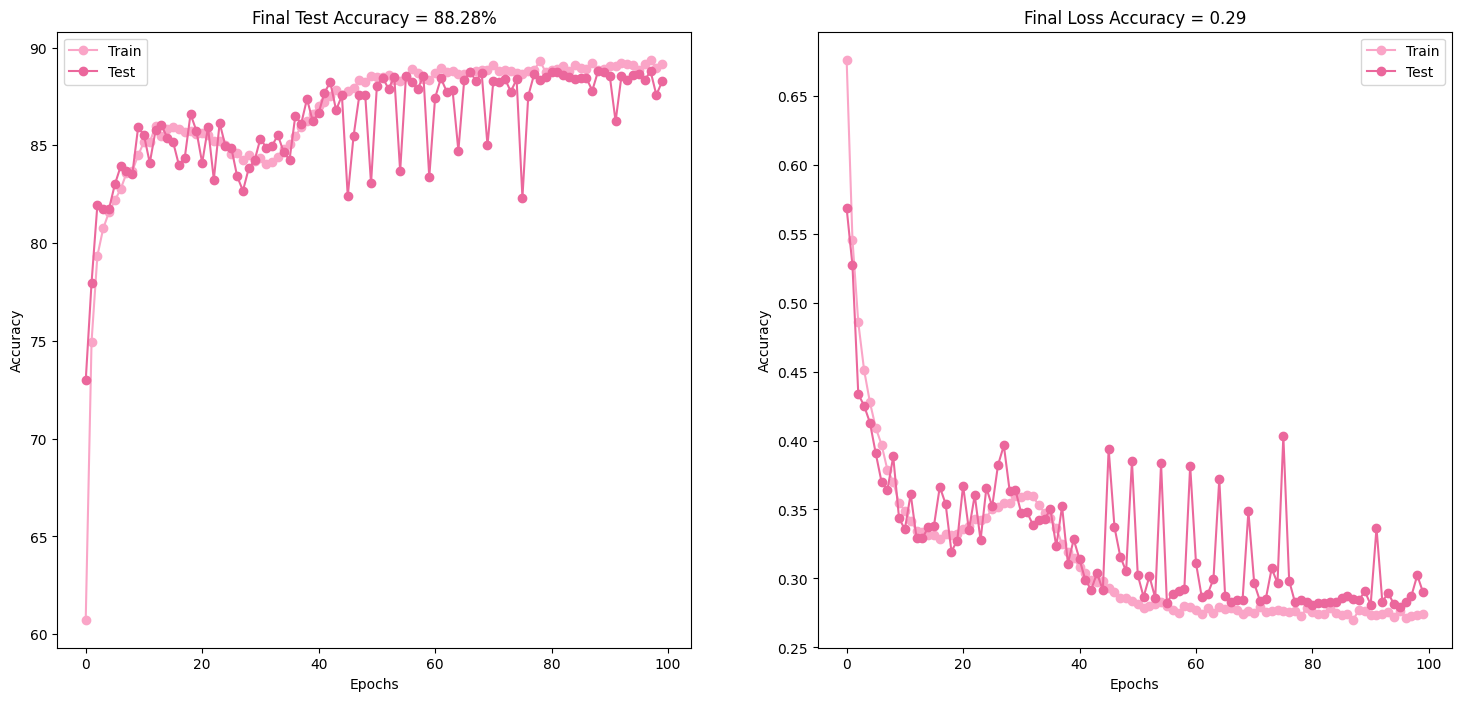

In [19]:
fig, ax = plt.subplots(1, 2, figsize = (18, 8))

ax[0].plot(trainAcc, 'o-', label = 'Train')
ax[0].plot(testAcc, 'o-', label = 'Test')
ax[0].set_title(f'Final Test Accuracy = {testAcc[-1]:.2f}%')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

ax[1].plot(trainLoss, 'o-', label = 'Train')
ax[1].plot(testLoss, 'o-', label = 'Test')
ax[1].set_title(f'Final Loss Accuracy = {testLoss[-1]:.2f}')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()

In [20]:
yTrue, yPred = [yT.item() for yT in yTrue], [yP.item() for yP in yPred]

<div style="background-color: #d40457; padding: 10px; border-radius: 8px;">
    <h1 style="color: #fff;">Plotting the Confusion Matrix</h1>
</div>

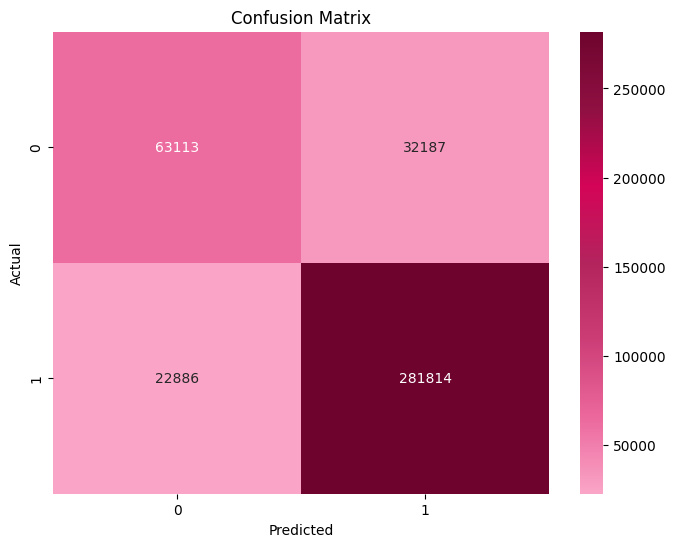

In [21]:
cm = confusion_matrix(yTrue, yPred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap=cmap, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<div style="background-color: #d40457; padding: 10px; border-radius: 8px;">
    <h1 style="color: #fff;">Evaluating the Results</h1>
</div>

In [22]:
precision = precision_score(yTrue, yPred)
recall = recall_score(yTrue, yPred)
f1Score = f1_score(yTrue, yPred)

In [23]:
html_code = f"""
    <div style="display: flex; flex-direction: row; justify-content: center; align-items: center; gap: 30px">
        <span>
            <h3 style="line-height: 30px; background-color: #cc3d76; padding: 20px 20px; border-radius: 8px">Precision {precision:.2f}</h3>
        </span>
        
        <span>
            <h3 style="line-height: 30px; background-color: #b3245d; padding: 20px 20px; border-radius: 8px">Recall {recall:.2f}</h3>
        </span>
        
        <span>
            <h3 style="line-height: 30px; background-color: #d40457; padding: 20px 20px; border-radius: 8px">F1-Score {f1Score:.2f}</h3>
        </span>
    </div>
"""
HTML(html_code)